In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd 'drive/My Drive/Siamese/Place'

/content/drive/My Drive/Siamese/Place


In [ ]:
import sys
sys.path.insert(0, '../Data')
sys.path.insert(0, '../Encoder')
sys.path.insert(0, '../Speaker')
sys.path.insert(0, '../Conference')
sys.path.insert(0, '..')

In [ ]:
!pip install torchaudio

In [ ]:
import os
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

from tqdm import tqdm

In [ ]:
DATASET_PATH = '/content/drive/My Drive/DataSet'
EPOCH_NUM = 10

torch.backends.cudnn.deterministic = True

NUM_WORKERS = 4

In [ ]:
from IdentificationDataset import IdentificationDataset
from IdentificationDataset import ReturnType
from torchvision.transforms import Compose

from Normalize import Normalize
from ToTensor import ToTensor

DATASET_PATH = '/content/drive/My Drive/DataSet'

transforms = Compose([
    Normalize(),
    ToTensor()
])

testset = IdentificationDataset(DATASET_PATH, 
                                20,
                                train=False, 
                                transform=transforms,
                                lenght=1,
                                return_type=ReturnType.STANDARD)
testsetloader = torch.utils.data.DataLoader(testset, 
                                            batch_size=1, 
                                            num_workers=NUM_WORKERS)

print("lenght test loader ", len(testsetloader))


sample lenght  1
lenght test loader  2134


In [ ]:
from Conference import Conference

# Define default device, we should use the GPU (cuda) if available
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = Conference(DEVICE, time=False)
net.to(DEVICE)

Conference(
  (encoder): TransFourier(
    (spectrogram): Spectrogram()
    (amp): AmplitudeToDB()
    (block1): Conv2DBlock(
      (conv1): Conv2d(1, 32, kernel_size=(1, 1), stride=(2, 1))
      (conv2): Conv2d(1, 96, kernel_size=(7, 7), stride=(2, 1), padding=(3, 3))
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (maxpool): MaxPool2d(kernel_size=(4, 4), stride=(4, 4), padding=0, dilation=1, ceil_mode=False)
    )
    (block2): Conv2DBlock(
      (conv1): Conv2d(128, 64, kernel_size=(1, 1), stride=(2, 1))
      (conv2): Conv2d(128, 192, kernel_size=(5, 5), stride=(2, 1), padding=(2, 2))
      (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (maxpool): MaxPool2d(kernel_size=(4, 2), stride=(4, 2), padding=0, dilation=1, ceil_mode=False)
    )
    (block3): Conv2DBlock(
      (conv1): Conv2d(256, 64, kernel_size=(1, 1), stride=(2, 1))
      (conv2): Co

In [ ]:
with torch.no_grad():
  # test
  net.eval()
  # Store the places
  speakers_list = testset.get_speakers_list(20)
  net.load_encoder()
  net.initspeakers(speakers_list)  
  net.initplaces(speakers_list, maxsize=6)

Encoder loaded


In [ ]:
import numpy as np

dict_error = {}
dict_nb = {}

with torch.no_grad():
  best_accuracy = 0
  mean_accuracies = []
  topk_accuracies = []
  min_accuracies = []
  final_mean_accuracies = []
  final_min_accuracies = []

  for epoch_num in range(EPOCH_NUM):
    print("*** Epoch ", epoch_num, " ***")
    mean_accuracy = 0
    topk_accuracy = 0
    min_accuracy = 0
    final_mean_accuracy = 0
    final_min_accuracy = 0
    nb_test = 0

    for speaker in speakers_list:
      id = speaker[0]
      dict_error[id] = 0
      dict_nb[id] = 0

    for iter_num, (gold_label, sample) in tqdm(enumerate(testsetloader)):
      mean_label, topk_label, min_label = net(sample, gold_label)
      final_mean_label, final_min_label = net(sample, place_id=gold_label)
      nb_test += 1
      gold_label = gold_label.item()
      dict_nb[gold_label] += 1

      if gold_label == mean_label:
        mean_accuracy += 1
      if gold_label == topk_label:
        topk_accuracy += 1
      else:
        dict_error[gold_label] += 1
      if gold_label == min_label:
        min_accuracy += 1
      if gold_label == final_mean_label:
        final_mean_accuracy += 1
      if gold_label == final_min_label:
        final_min_accuracy += 1

    mean_accuracy /= nb_test
    topk_accuracy /= nb_test
    min_accuracy /= nb_test
    final_mean_accuracy /= nb_test
    final_min_accuracy /= nb_test
    mean_accuracies.append(mean_accuracy)
    topk_accuracies.append(topk_accuracy)
    min_accuracies.append(min_accuracy)
    final_mean_accuracies.append(final_mean_accuracy)
    final_min_accuracies.append(final_min_accuracy)
    print("accuracy mean ", mean_accuracy, "topk", topk_accuracy, 
          " min ", min_accuracy)
    print("accuracy final_mean ", final_mean_accuracy, 
          " final_min ", final_min_accuracy)
    add = 0
    nb = 0
    for id in dict_error:
      add += dict_error[id]
      nb += dict_nb[id]
      dict_error[id] =  100 * dict_error[id]//dict_nb[id] 
    print("Error ", add/nb)
    print(dict_error)

  net.store_speakers(20, 3)

*** Epoch  0  ***


2134it [01:39, 21.38it/s]

accuracy mean  0.34629803186504216 topk 0.5084348641049672  min  0.4817244611059044
accuracy final_mean  0.7591377694470478  final_min  0.662136832239925
Error  0.4915651358950328
{270: 22, 272: 52, 273: 37, 274: 22, 275: 74, 276: 48, 277: 80, 278: 29, 271: 100, 279: 87, 280: 44, 281: 58, 282: 46, 283: 54, 285: 97, 284: 64, 286: 10, 287: 95, 288: 77, 289: 13}
*** Epoch  1  ***



2134it [01:40, 21.16it/s]

accuracy mean  0.43673851921274603 topk 0.5721649484536082  min  0.5079662605435802
accuracy final_mean  0.8847235238987816  final_min  0.788659793814433
Error  0.42783505154639173
{270: 24, 272: 40, 273: 43, 274: 18, 275: 54, 276: 43, 277: 59, 278: 26, 271: 76, 279: 73, 280: 41, 281: 57, 282: 34, 283: 48, 285: 76, 284: 45, 286: 10, 287: 68, 288: 62, 289: 20}
*** Epoch  2  ***



2134it [01:40, 21.22it/s]

accuracy mean  0.45126522961574506 topk 0.5829428303655108  min  0.514526710402999
accuracy final_mean  0.9400187441424555  final_min  0.8252108716026242
Error  0.41705716963448924
{270: 27, 272: 48, 273: 47, 274: 20, 275: 40, 276: 48, 277: 49, 278: 27, 271: 54, 279: 55, 280: 41, 281: 53, 282: 32, 283: 50, 285: 72, 284: 36, 286: 15, 287: 52, 288: 64, 289: 25}
*** Epoch  3  ***



2134it [01:40, 21.22it/s]

accuracy mean  0.49953139643861294 topk 0.6073102155576382  min  0.5360824742268041
accuracy final_mean  0.9625117150890347  final_min  0.8406747891283973
Error  0.39268978444236174
{270: 30, 272: 48, 273: 55, 274: 20, 275: 37, 276: 44, 277: 43, 278: 23, 271: 41, 279: 44, 280: 35, 281: 44, 282: 25, 283: 48, 285: 55, 284: 36, 286: 18, 287: 47, 288: 56, 289: 28}
*** Epoch  4  ***



2134it [01:46, 20.06it/s]

accuracy mean  0.5276476101218369 topk 0.6138706654170571  min  0.5454545454545454
accuracy final_mean  0.9700093720712277  final_min  0.8472352389878163
Error  0.38612933458294285
{270: 31, 272: 44, 273: 57, 274: 22, 275: 25, 276: 44, 277: 44, 278: 25, 271: 36, 279: 34, 280: 34, 281: 46, 282: 28, 283: 48, 285: 48, 284: 34, 286: 17, 287: 43, 288: 47, 289: 32}
*** Epoch  5  ***



2134it [01:40, 21.17it/s]

accuracy mean  0.5595126522961574 topk 0.6091846298031866  min  0.5463917525773195
accuracy final_mean  0.9671977507029054  final_min  0.8411433926897844
Error  0.3908153701968135
{270: 31, 272: 40, 273: 60, 274: 24, 275: 24, 276: 45, 277: 38, 278: 25, 271: 30, 279: 33, 280: 32, 281: 48, 282: 28, 283: 51, 285: 54, 284: 35, 286: 19, 287: 41, 288: 41, 289: 32}
*** Epoch  6  ***



2134it [01:40, 21.27it/s]

accuracy mean  0.5641986879100281 topk 0.6059044048734771  min  0.5435801312089972
accuracy final_mean  0.9690721649484536  final_min  0.8317713214620431
Error  0.394095595126523
{270: 30, 272: 40, 273: 62, 274: 24, 275: 28, 276: 46, 277: 32, 278: 27, 271: 27, 279: 30, 280: 29, 281: 50, 282: 32, 283: 52, 285: 54, 284: 34, 286: 20, 287: 35, 288: 41, 289: 32}
*** Epoch  7  ***



2134it [01:40, 21.21it/s]

accuracy mean  0.5627928772258669 topk 0.5998125585754451  min  0.5407685098406748
accuracy final_mean  0.9704779756326148  final_min  0.8388003748828491
Error  0.4001874414245548
{270: 28, 272: 40, 273: 64, 274: 25, 275: 28, 276: 47, 277: 31, 278: 30, 271: 28, 279: 30, 280: 29, 281: 50, 282: 32, 283: 52, 285: 56, 284: 33, 286: 22, 287: 35, 288: 41, 289: 33}
*** Epoch  8  ***



2134it [01:40, 21.15it/s]

accuracy mean  0.5548266166822868 topk 0.5937207122774133  min  0.5412371134020618
accuracy final_mean  0.9634489222118088  final_min  0.8383317713214621
Error  0.4062792877225867
{270: 28, 272: 40, 273: 64, 274: 25, 275: 28, 276: 45, 277: 29, 278: 29, 271: 28, 279: 31, 280: 32, 281: 50, 282: 33, 283: 54, 285: 62, 284: 35, 286: 22, 287: 35, 288: 43, 289: 34}
*** Epoch  9  ***



2134it [01:40, 21.19it/s]


accuracy mean  0.5595126522961574 topk 0.5965323336457357  min  0.542642924086223
accuracy final_mean  0.9643861293345829  final_min  0.830834114339269
Error  0.4034676663542643
{270: 29, 272: 44, 273: 63, 274: 25, 275: 28, 276: 47, 277: 31, 278: 28, 271: 31, 279: 25, 280: 32, 281: 55, 282: 34, 283: 52, 285: 60, 284: 31, 286: 22, 287: 35, 288: 39, 289: 34}


In [ ]:
print("maximum of min", round(np.max(min_accuracies), 3))
print("maximum of topk", round(np.max(topk_accuracies), 3))
print("maximum of mean", round(np.max(mean_accuracies), 3))
print("maximum of final mean", round(np.max(final_mean_accuracies), 3))
print("maximum of final min", round(np.max(final_mean_accuracies), 3))

maximum of min 0.546
maximum of topk 0.614
maximum of mean 0.564
maximum of final mean 0.97
maximum of final min 0.97


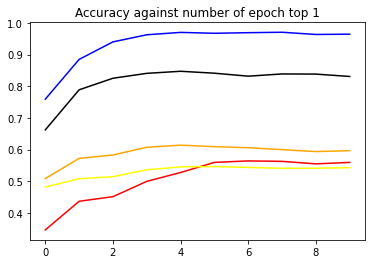

In [ ]:
import matplotlib.pyplot as plt

plt.title("Accuracy against number of epoch top 1")
plt.plot([i for i in range(EPOCH_NUM)], mean_accuracies , label='test 1', color='red')
plt.plot([i for i in range(EPOCH_NUM)], topk_accuracies , label='test 1', color='orange')
plt.plot([i for i in range(EPOCH_NUM)], min_accuracies , label='test 1', color='yellow')
plt.plot([i for i in range(EPOCH_NUM)], final_mean_accuracies , label='test 1', color='blue')
plt.plot([i for i in range(EPOCH_NUM)], final_min_accuracies , label='test 1', color='black')

In [ ]:
import numpy as np
import torch as th

with torch.no_grad():
  min_accuracies = []
  mean_accuracies = []
  
  for epoch_num in range(1):
    print("*** Epoch ", epoch_num, " ***")
    mean_accuracy = 0
    min_accuracy = 0
    nb_test = 0

    for iter_num, (gold_label, sample) in tqdm(enumerate(testsetloader)):
      mean_label, min_label = net.forward(sample, place_id=gold_label)
      nb_test += 1
      if gold_label == mean_label:
        mean_accuracy += 1
      if gold_label == min_label:
        min_accuracy += 1

    mean_accuracy /= nb_test
    min_accuracy /= nb_test
    mean_accuracies.append(mean_accuracy)
    min_accuracies.append(min_accuracy)
    print("accuracy mean ", mean_accuracy, "min", min_accuracy)


*** Epoch  0  ***


2134it [00:54, 39.43it/s]

accuracy mean  0.9629803186504218 min 0.8261480787253983
